In [1]:
import gradio as gr
import pandas as pd
import numpy as np
from joblib import dump, load
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, RocCurveDisplay
from sklearn.metrics import roc_curve,ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

In [2]:
clf = load("RandomForestClassifier()20.joblib")
modelname = "Random Forest"

In [3]:
def encode(data, employement):
    data['work_type'] = data['work_type'].replace({'Goverment job' : 'Govt_job',
                                                   "Never worked" : "Never_worked",
                                                   "Self-employed" : "Self-employed"})
    data_jobs = ['Govt_job', 'Never_worked','Private','Self-employed']
    for job in data_jobs:
        if data['work_type'][0] == job:
            data[job] = 1
        else:
            data[job] = 0
    return data
none_argument = lambda y: -999 if type(y) == list else y
def replace_with_numeric(data):
    data['ever_married'] = data['ever_married'].apply(none_argument)
    data['ever_married'] = data['ever_married'].replace({'Yes' : 1 , 'No' : 0 })
    
    data['residence_type'] = data['residence_type'].replace({'Urban' : 1 , 'Rural' : 0, '' : -999})
    
    data['smoking_status'] = data['smoking_status'].apply(none_argument)
    data['smoking_status'] = data['smoking_status'].replace({'Never smoked' : 0 , 'Formerly smoked' : 1, 
                                                            'Smokes': 2})
    
    data['gender'] = data['gender'].replace({'Male' : -1 , 'Female' : 1, 'Other' : 1, '' : -999})
    
    data['avg_glucose_level'] = data['avg_glucose_level'].apply(none_argument)
    data['avg_glucose_level'] = data['avg_glucose_level'].replace({"Normal (<100 mg/dL)" : 0,
                                                                   "Prediabetes (<100, 125> mg/dL)" : 1,
                                                                   "Diabetes (>125 mg/dL)" : 2})
    
    data['bmi'] = data['bmi'].apply(none_argument)
    data['bmi'] = data['bmi'].replace({"Underweight (<18.4)" : 0, "Normal (<18.5, 24.9>)" : 1,
                                    "Overweight (<25, 29.9>)" : 2,"Obese (>29.9)" : 3})
    return data
def change_dtype(data):
    data['age'].astype('int32')
    data['Govt_job'].astype(pd.SparseDtype('int32', 0))
    data['Never_worked'].astype(pd.SparseDtype("int32", 0))
    data['Private'].astype(pd.SparseDtype("int32", 0))
    data['Self-employed'].astype(pd.SparseDtype("int32", 0))
    data.info()
    return data


In [4]:
def predict_stroke_from_one_patient(
    gender, age, hypertension, heartDisease,
    everMarried, residenceType, averageGlucoseLevel,
    bmi, smokingStatus, employementType):
    if type(bmi) == list:
        d = {'gender': [gender], 'age': [age], 'hypertension': [hypertension], 
             'heart_disease': [heartDisease], 'ever_married': [everMarried],
             'residence_type': [residenceType],'avg_glucose_level': [averageGlucoseLevel], 
             'bmi': [bmi], 'smoking_status': [smokingStatus], 'bmi_was_missing' : True, 'work_type': [employementType]}
    else:
        d = {'gender': [gender], 'age': [age], 'hypertension': [hypertension], 
             'heart_disease': [heartDisease], 'ever_married': [everMarried],
             'residence_type': [residenceType],'avg_glucose_level': [averageGlucoseLevel], 
             'bmi': [bmi], 'smoking_status': [smokingStatus], 'bmi_was_missing' : False, 'work_type': [employementType]}  
    data = pd.DataFrame(data=d)
    data = pd.DataFrame(data=d)
    encode(data, employementType)
    data = data.drop("work_type", axis = 1)
    data = replace_with_numeric(data)
    #data = change_dtype(data)
    y_predicted = clf.predict(data)
    if y_predicted == 1:
        prediction = 'stroke'
    else:
        prediction = 'no stroke'
    return prediction

In [5]:
demo2 = gr.Interface(predict_stroke_from_one_patient,
                   [
                       gr.Radio(["Male", "Female", "Other"]),
                       gr.Slider(40, 90, value=40, step=1),
                       gr.Checkbox(label="Hypertension"),
                       gr.Checkbox(label="Heart Disease"),
                       gr.Checkbox(label="Is/Was Married?"),
                       gr.Radio(["Urban", "Rural"]),
                       gr.Dropdown(["Normal (<100 mg/dL)", "Prediabetes (<100, 125> mg/dL)",
                                    "Diabetes (>125 mg/dL)"]),
                       gr.Dropdown(["Underweight (<18.4)", "Normal (<18.5, 24.9>)",
                                    "Overweight (<25, 29.9>)","Obese (>29.9)"]),
                       gr.Dropdown(["Never smoked", "Formerly smoked","Smokes"]),
                       gr.Dropdown(["Goverment job", "Never worked", "Private",
                                    "Self-employed"])],
                   outputs="label")

In [6]:
def bmi(col):
    if col <= 18.4: #Underweight
        return 0
    elif col >= 18.5 and col <= 24.9: #normal
        return 1
    elif col >= 25.0 and col <= 29.9: #Overweight (Pre-obese)
        return 2
    else: #obese
        return 3
def glucose(col):
    if col >= 100 and col <= 125: #prediabetes
        return 1
    elif col < 100: #normal
        return 0
    else: # diabetes
        return 2
def smoking_status(col):
    if col == 'never smoked':
        return 0
    elif col == 'formerly smoked':
        return 1
    elif col == 'smokes':
        return 2
    else:
        return -999

In [7]:
def fill_with_median(data):
    bmi_num = data[["bmi"]]
    #MEDIAN OF BMI VALUES
    bmi_median = bmi_num.median()
    bmi_plus = bmi_num.copy()
    bmi_plus['bmi'] = bmi_plus.isnull()
    bmi_plus.columns = ['bmi_was_missing']
    data = data.fillna(bmi_median)
    data = data.join(bmi_plus)
    return data
def encode_1H(data):
    cat_encoder = OneHotEncoder()
    work_cat = data[["work_type"]]
    work_cat_1hot =pd.DataFrame.sparse.from_spmatrix(cat_encoder.fit_transform(work_cat))
    work_cat_1hot.columns = ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children']
    work_cat_1hot = work_cat_1hot.astype(int)
    data = data.join(work_cat_1hot)
    data = data.drop("work_type", axis = 1)
    return data
def replace_with_numeric(data):
    data['age'] = data['age'].astype(int)
    data['ever_married'] = data['ever_married'].replace({'Yes' : 1 , 'No' : 0 })
    data['residence_type'] = data['residence_type'].replace({'Urban' : 1 , 'Rural' : 0 })
    data.smoking_status = data.smoking_status.apply(smoking_status)
    data['gender'] = data['gender'].replace({'Male' : -1 , 'Female' : 1 , 'Other': 1})
    data.avg_glucose_level = data.avg_glucose_level.apply(glucose)
    data.bmi = data.bmi.apply(bmi)
    return data

In [8]:
def rf_feat_importance(df):
    return pd.DataFrame({'Feature':df.columns,
                         'Importance':clf.feature_importances_}).sort_values('Importance', ascending=False)
def plot_importance(df):
    fi = rf_feat_importance(model_data)

    fig, ax = plt.subplots(1,1, figsize=(10, 8))

    sns.barplot(data=fi,x='Importance',y='Feature',ax=ax)
    for s in ['top', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    fig.text(0.12,0.92,"Feature Importance: "+ modelname +" Stroke Prediction", fontsize=18, fontweight='bold', fontfamily='serif')
    
    plt.xlabel(" ", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
    plt.ylabel(" ", fontsize=12, fontweight='light', fontfamily='serif')

    import matplotlib.lines as lines
    l1 = lines.Line2D([0.98, 0.98], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
    fig.lines.extend([l1])
    return fig

In [9]:
def predict_stroke_from_csv(file):
   # print(file.name)
    data = pd.read_csv(file)
    data.columns = data.columns.str.lower()
    if data.isna().any().any() == True:
        print('Missing values detected. Filling with median of feature values')
        data = fill_with_median(data)
    data = encode_1H(data)
    if data['age'].where(data['age'] < 40).any():
        print("Patients younger than 40 years old detected. " +
              "Diagnose of younger than 40 years old can be false")
              #"Dropping the data about too young for model to predict stroke")
        #data = data.drop(data[data.age < 40].index)
    data = data.drop(['children'],axis=1)
    data = replace_with_numeric(data)
    data = data.drop(['stroke'],axis=1)
    model_data = data.drop(['id'],axis=1)
    y_predicted = clf.predict(model_data)
    y_predicted_proba = clf.predict_proba(model_data)
    predictions = []
    proba_predictions = []
    i = 0
    for y in y_predicted:
        if y == 1:
            predictions.append(data._get_value(i, 'id'))
            proba_predictions.append(y_predicted_proba[i, 1].round(2))
        i = i + 1
    prob = pd.DataFrame({'ID': predictions, 'Probability of stroke': proba_predictions})
    plot = plot_importance(df = model_data)
    return prob, plot

In [10]:
with gr.Blocks() as demo3:
    gr.Markdown(
    """
    # Predict stroke fo multiple patients
    Upload a CSV file with data about your patients to get IDs of patients at risk of stroke with probability > 50%
    """)
    filename = gr.File(file_types=[".csv"])
    button = gr.Button("Zatwierdź")
    plot = gr.Plot(label="Plot")
    outputs = gr.Dataframe(row_count = (1, "dynamic"),
                           col_count=(1, "dynamic"), label="Predictions",
                           headers=["ID"])
    button.click(fn=predict_stroke_from_csv, inputs=filename, outputs=[outputs, plot])

In [11]:
recallScore = load("recall.joblib")
recallDT = recallScore.loc[:, modelname]
precisionScore = load("precision.joblib")
precisionDT = precisionScore.loc[:, modelname]
accuracy = load("accuracy.joblib")
accuracyDT = accuracy.loc[:, modelname]
score = {'Recall' : recallDT, 'Precision' : precisionDT, 'Accuracy' : accuracyDT}
df = pd.DataFrame(score)
df.reset_index(inplace=True)

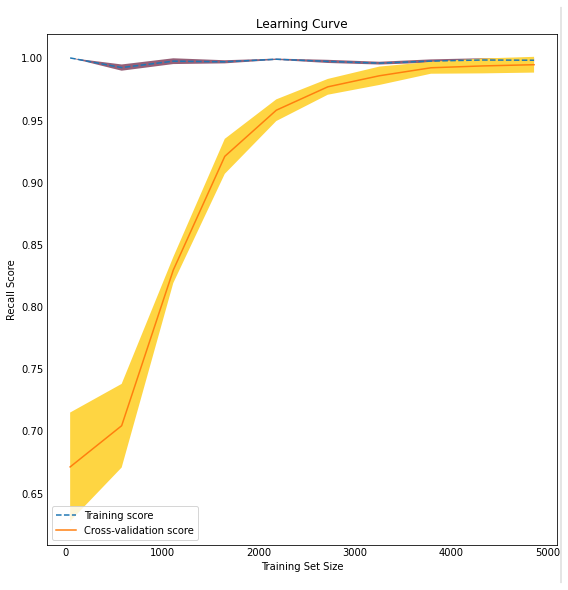

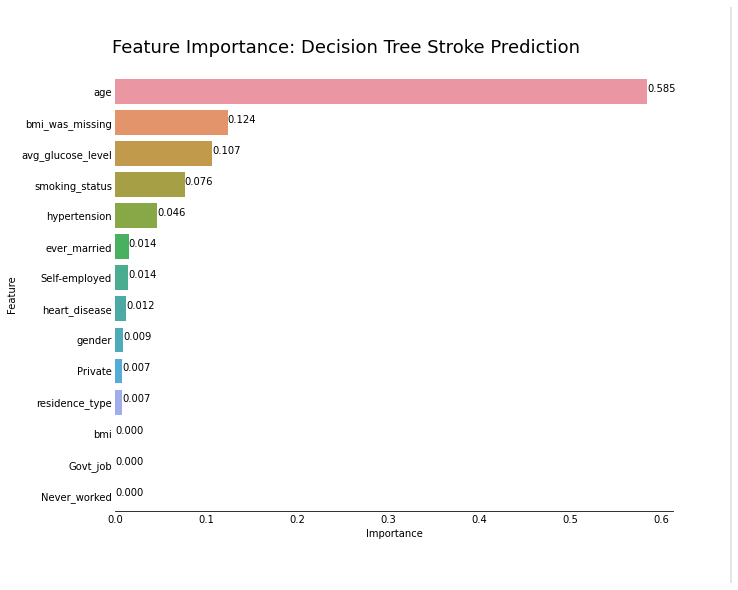

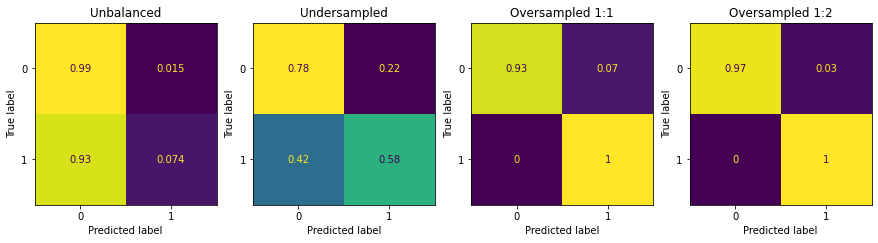

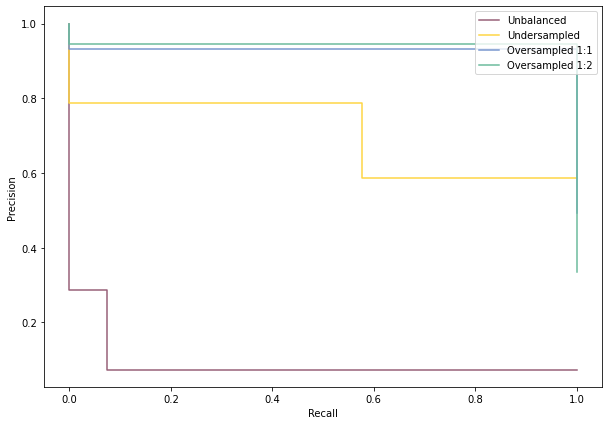

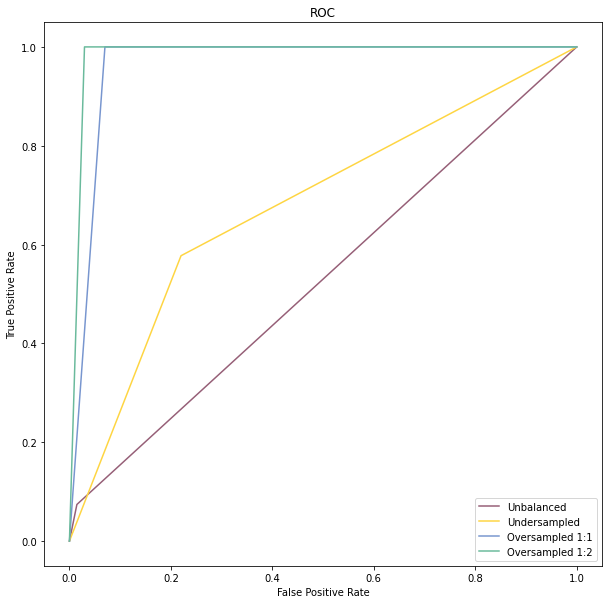

In [12]:
learning = load("learning.joblib")
importance = load("importance.joblib")
matrixes = load("matrixes.joblib")
recCurve = load("recCurve.joblib")
roc = load("roc.joblib")

In [13]:
with gr.Blocks() as demo4:
    gr.Markdown(
    """
    # Random Forest
    """),
    with gr.Row():
        with gr.Column():
            plot4 = gr.Plot(recCurve, show_label = False)
        with gr.Column():
            plot1 = gr.Plot(importance, show_label = False)
    with gr.Row():
            plot2 = gr.Plot(learning, show_label = False)
            plot4 = gr.Plot(roc, show_label = False)
    with gr.Row():
            plot3 = gr.Plot(matrixes, show_label = False)
            scores = gr.Dataframe(df, label="Metrics scores")

In [14]:
with gr.Blocks() as demo:
    with gr.Tab("Model Overwiew"):
        demo4.render()
    with gr.Tab("Predict Stroke"):
        demo2.render()
    with gr.Tab("Predict Stroke CSV"):
        demo3.render()
demo.launch()

Running on local URL:  http://127.0.0.1:7896

To create a public link, set `share=True` in `launch()`.
